<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [119]:
%%capture
pip install pyswarms

In [120]:
%%capture
pip install scipy

In [121]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 10000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 4000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/'
NOME_ARQUIVO_PRINCIPAL = 'melhor_custo_pso_primeiro_cenario'
NOME_ARQUIVO_TEMPO_SEVERIDADE = '_tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '01'

In [124]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [125]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [126]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [127]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [128]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [129]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [130]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [131]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [132]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [133]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [134]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [135]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-11-14 18:01:02,400 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-2.17e-24
2023-11-14 18:01:02,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.1695816722352754e-24, best pos: [125.00575881   1.9984432    0.18335063]


In [136]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 125.0057588147275
beta: 1.9984431999699197
theta: 0.18335063133595905

Tempo de Convergência para a primeira etapa: 0.009042024612426758 segundos


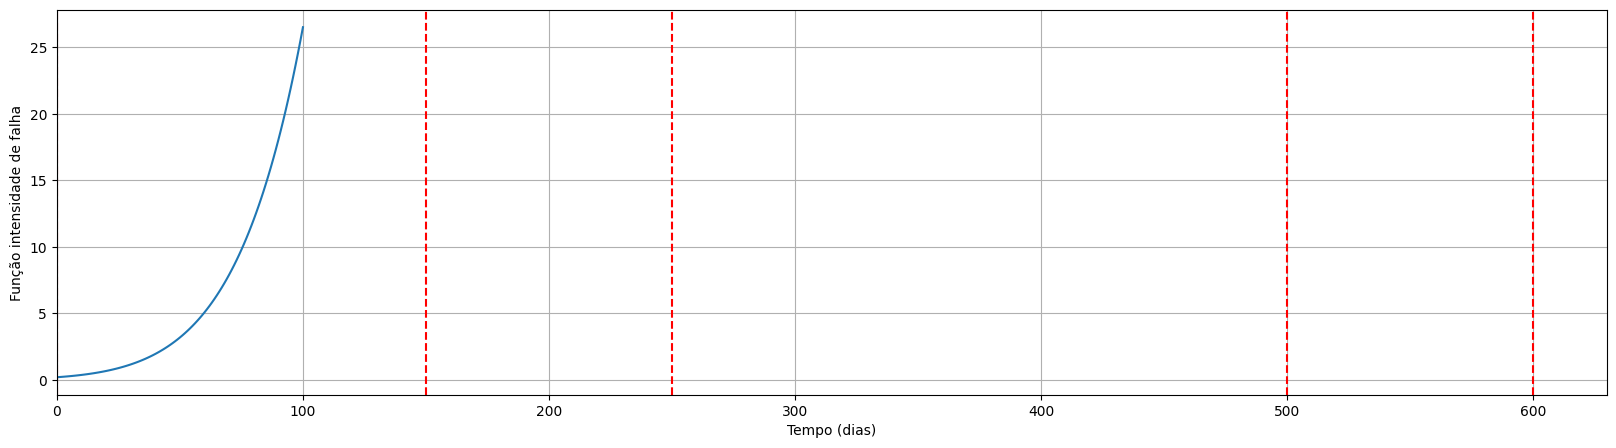

Fator ajuste:  [0.08999823965563203, 0.11120256918754023, 0.19119277337111007, 0.04605987591234639]


In [137]:
#beta = beta * 5

lamb = 123.4695452138145
beta = 9.922219935162067
theta = 0.23577186257188001

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [138]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [139]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-11-14 18:01:03,995 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=1.55e+8<ipython-input-138-c2968896f09c>:80: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=1.55e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 27, 39, 104, 140, 191, 240, 286, 303, 378, 448, 455, 633, 714]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023]
Media de falhas:  [0, 2.814422221298192e-07, 7.945393077876061e-06, 0.0978037366213622, 1.040431379148489, 22.066610151816157, 290.10094138990695, 1639.0604660205183, 2340.8752486217827, 39828.005816887904, 221832.16459847108, 242801.38798587414, 7291119.653906599, 22897544.567753423, 17361010.31560024]
Custo =  1148031896.8419087


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 43, 80, 105,

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=8.12e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 2, 164, 209, 299, 308, 351, 397, 461, 512, 649, 717]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 1.7138349691891668e-18, 16.627608676211494, 86.36422910307962, 2018.147574995939, 2487.8243693570225, 7920.617056088047, 54638.96476195143, 196188.2202981637, 395366.61705661035, 8592341.262157658, 17473271.557023227, 7243026.183260538]
Custo =  1140828287.484768


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 19, 198, 303, 356, 419, 457, 656, 671]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75]
Número

pyswarms.single.global_best:  40%|████      |40/100, best_cost=8.12e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 38, 124, 355, 388, 455, 488, 645, 676, 711]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 8.356866636091208e-06, 0.9061858881019399, 29106.259000704827, 59668.289643391974, 188283.5061893752, 340881.91570507, 8452886.775467522, 10154668.619753974, 15117264.115030106, -1144888.8760900293]
Custo =  1609821893.0808542


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 49, 132, 201, 356, 389, 457, 490, 639, 668, 713]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.057239462

pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=8.12e+7


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 8, 141, 304, 355, 457, 480, 567, 682]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 1.6133947821779543e-12, 3.63774208971125, 3518.126929451557, 20864.24403791673, 278612.8681077478, 377021.8572800856, 2244795.483566632, 7109922.652889365, -2456730.6944890656]
Custo =  750433867.395584


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 21, 127, 293, 304, 354, 454, 566, 578, 656, 702]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.1112

pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=8.12e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 55, 146, 173, 293, 349, 398, 453, 497, 634]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023]
Media de falhas:  [0, 3.801985330896059e-11, 0.00029885785470202755, 3.4505322056265073, 17.893604704585826, 3766.7856253317027, 19238.40442519036, 38205.13170418781, 147901.88652926573, 370942.92531837, 6928000.879925646, 5993926.117219976]
Custo =  332374153.21955055


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 39, 351, 407, 454, 504, 580, 639, 713]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.0

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 15, 126, 188, 353, 389, 411, 454, 482, 510, 567, 654, 695]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 8.251241760216549e-10, 1.1580521692203027, 21.660377035585324, 24717.44459863075, 37081.07310529251, 60182.00658351782, 155431.92623357155, 354553.70958442334, 688228.6654506985, 1240037.9104153635, 5674674.082259443, 13283176.925219968, 6268825.526930737]
Custo =  1371399044.2846894


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 130, 272, 300, 351, 454, 481, 560, 645, 668, 718]
Severidade para cad

pyswarms.single.global_best:  89%|████████▉ |89/100, best_cost=8.12e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 65, 146, 300, 350, 455, 485, 577, 650]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 0.0017187322413964768, 4.295862407679886, 2965.3135024812595, 17990.485526841407, 267719.36306117487, 401693.07771709387, 2665007.670206561, 4979220.751093345, 413685.82912167907]
Custo =  619110468.6042211


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 32, 62, 141, 167, 200, 350, 403, 456, 481, 652]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.0572394626351

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=8.12e+7
2023-11-14 18:01:05,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60272393 1.01848853 5.36162912 4.37889949 0.73891153 6.36766464
 0.65291474 6.65883718 4.18374387 6.64405875 0.88372467 3.50407123
 3.94254193 0.24265449 2.01920857 1.2021181  5.93084386 3.08935526
 1.6799921  3.10855183 4.62197151 2.72058453 0.51897379 5.7026641 ]
2023-11-14 18:01:05,549 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 31, 136, 352, 453, 581]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 1.10841375096789e-06, 2.3498746304057625, 26187.050747854668, 262314.4779036737, 2057089.228622868, 3115736.04378883]
Custo =  288797144.5529736


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 89, 146, 151, 279, 349, 389, 453, 493, 568, 571, 651, 662, 705]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:05,577 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59384693 1.01852715 5.35923076 4.37993627 0.74334314 1.60089063
 0.77151525 6.66092292 4.18533265 1.85777646 0.88274414 3.53209407
 3.94313263 0.24672799 2.02071442 1.20305869 5.92419797 3.04985739
 1.68043904 3.16206271 4.61503793 2.72438196 0.51840218 3.51505956]
2023-11-14 18:01:05,585 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 24, 51, 146, 204, 302, 347, 389, 415, 453, 563, 632, 679, 704]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 8.74666862342486e-08, 0.0001246391889980905, 4.317566080333263, 97.64938545207187, 4850.7487938432, 12962.549826254985, 49552.94119155196, 78372.1036208426, 163933.76213685604, 958005.391629572, 5503631.183825025, 12314862.0684537, 15726374.601054683, 7500624.1630209675]
Custo =  1752133983.471451


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:05,608 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59353794 1.01848627 5.35769966 4.3803109  0.7523151  4.35705223
 0.83458395 6.66464553 4.19067613 0.89957432 0.88349529 3.57492553
 3.94284698 0.24338023 2.01801656 1.20383692 5.93957461 3.05499079
 1.68221404 3.16015604 4.62100686 2.72400427 0.51764949 3.18663882]
2023-11-14 18:01:05,616 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 141, 180, 294, 302, 346, 389, 419, 454, 562]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 3.7334290336368934, 30.639494457780636, 3851.7285976296944, 4444.865477408563, 9276.656236777855, 46393.88531355952, 81507.42731271623, 163751.23135386134, 936179.1013913031, 2804520.719337718]
Custo =  243683786.5414821


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:05,643 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59425332 1.01844948 5.3567521  4.38057968 0.75856112 6.17596281
 1.54471183 6.66634054 4.19542844 6.34653459 0.88418637 3.59330219
 3.94257187 0.24020237 2.01572344 1.20421113 5.95190968 3.06222968
 1.68328484 3.14767973 4.626567   2.72286854 0.51704058 2.80707474]
2023-11-14 18:01:05,645 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 62, 132, 301, 344, 407, 455, 560, 664]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 0.0010754438219905216, 1.5622385546039663, 3329.7626053673953, 15105.252285413493, 85009.60658105733, 189709.54218549762, 924271.9011439368, 9964861.428694138, 3465882.8245109525]
Custo =  796222602.5788457


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 6, 75, 122, 343, 389, 415, 455, 559]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 9.291183234458851e-14, 0.006854025677601452, 0.6252507491092892, 14027.471868959838, 52658.7607821039, 81477.92321139453, 173897.95239815064, 892148.4510423015, 2869564.2683481686]
Custo =  237833765.2398203



2023-11-14 18:01:05,697 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59683044 1.01842417 5.35704622 4.38032166 0.76137518 0.12014255
 2.88113017 6.66603585 4.19733968 3.56272005 0.88467497 3.59310265
 3.94231676 0.23803192 2.01404444 1.20433568 5.9589645  3.07391269
 1.68335742 3.1268815  4.63030655 2.72173087 0.5165535  2.09224857]
2023-11-14 18:01:05,699 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 9, 57, 87, 276, 341, 389, 393, 456, 511, 557, 589, 692]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 5.191432672466099e-12, 0.00043431644457565246, 0.010531772297542253, 2442.6375866826957, 7847.480339095246, 22986.272275495074, 26294.3724398636, 152965.38529331272, 359366.5442041401, 1441886.0711114206, 2272541.978691976, 15554485.568981659, 3950155.5047597717]
Custo =  1246316603.4651628



2023-11-14 18:01:05,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60083793 1.01840419 5.35844886 4.37979804 0.75996047 1.00037383
 4.46909272 6.66380996 4.19898645 0.00691121 0.8849633  3.57108547
 3.94213028 0.23726873 2.01396807 1.20437758 5.96244834 3.08740885
 1.68281827 3.10657166 4.63344719 2.72043536 0.51673055 1.72612792]
2023-11-14 18:01:05,780 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 44, 298, 341, 389, 456, 514, 557, 672]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 3.5791680092085726e-05, 5853.226027641525, 16701.757492792734, 41148.61410300013, 172431.15458224097, 539222.4188702826, 1571891.4707495505, 8266749.233450275, 492348.8491024086]
Custo =  797110653.6125524


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:05,868 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60486881 1.01840563 5.36025974 4.37920333 0.75251992 1.40243094
 5.92997992 6.66141937 4.19655807 3.57178719 0.88501361 3.54526559
 3.94199868 0.23709725 2.01532357 1.20429283 5.96023396 3.10000615
 1.68156386 3.0885969  4.63375457 2.71930039 0.51715837 1.8140613 ]
2023-11-14 18:01:05,871 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:05,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60814107 1.01842196 5.36228868 4.37857831 0.7442516  2.53792555
 6.56695917 6.6586104  4.19251366 6.90648248 0.88487763 3.52160931
 3.94197901 0.2377245  2.01714357 1.20418255 5.95503557 3.10907645
 1.6801642  3.077240



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 202, 341, 388, 457, 516, 557, 580]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 132.21675418417877, 18180.37141353143, 56365.09855998928, 192626.73396104827, 577073.4771221945, 1575218.7482091323, 2123956.0447613373, 3230861.0560215916]
Custo =  451929410.0137683


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:05,958 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60984988 1.01844892 5.36404596 4.37810805 0.73664905 3.40711869
 6.66218527 6.65612805 4.18715487 2.19823368 0.88441975 3.49694815
 3.94210025 0.23866894 2.01937004 1.20392902 5.94458838 3.11723801
 1.67886778 3.07487564 4.63288422 2.71852098 0.51866035 1.93641197]
2023-11-14 18:01:05,959 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 292, 342, 388, 402, 457, 503, 517, 557, 686, 719]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023]
Media de falhas:  [0, 5118.633708161301, 18408.088597208516, 56121.625599492225, 69035.05560163101, 188074.13660249193, 345059.5610597769, 555568.1286056527, 915067.6700749113, 9543646.86532652, 18271251.2156054, 12269461.295893356]
Custo =  1653692779.2507615


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 9, 145, 269, 280, 343, 388, 457, 495, 518, 558, 683]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 5.191432672466099e-12, 4.789771400479152, 919.4823280508281, 1156.6151321558687, 9943.015322133611, 47175.113460080276, 183436.7488611393, 376777.64447387157, 704998.9905687317, 1070442.0245002443, 9217616.183109906, -541288.8009275459]
Custo =  856881026.3271091


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:05,977 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.61070302 1.01847747 5.36512127 4.37783879 0.73018299 4.20167255
 0.31728525 6.65466041 4.18216866 3.59412274 0.88386448 3.47647084
 3.94228908 0.24056017 2.02132861 1.20344599 5.9337849  3.12305549
 1.67800587 3.08273806 4.63142844 2.71899393 0.51942301 2.30483719]
2023-11-14 18:01:05,979 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.61066334 1.01850339 5.3658451  4.37772068 0.72442777 4.68935359
 1.63999443 6.6536697  4.17783355 4.15761625 0.88336067 3.46108433
 3.94246506 0.24226361 2.02257474 1.20300631 5.92401729 3.12597122
 1.67768395 3.092374



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 86, 152, 191, 269, 279, 344, 387, 457, 491, 517, 560, 679]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 0.027644088418048034, 6.0641323957438615, 23.975398360840746, 1003.1742586099729, 1214.3809551745676, 10390.59141730952, 45766.94603521463, 183137.77938740957, 348263.8476335035, 704566.4939441045, 1103924.1294173112, 8618087.215897484, -386409.1041317992]
Custo =  831736374.9601737


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,037 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60884376 1.0185264  5.36526859 4.37773788 0.72127485 4.78955267
 3.47303489 6.65364461 4.17450666 4.60761862 0.88292616 3.45328184
 3.94262834 0.24387018 2.02344379 1.20255055 5.91562679 3.12373646
 1.67757331 3.10336792 4.62554681 2.71983719 0.52051568 2.52725668]
2023-11-14 18:01:06,041 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 11, 39, 80, 162, 204, 345, 387, 411, 456, 492, 515, 561, 630, 703]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 3.801985330896059e-11, 9.49792073666081e-06, 0.007764765330133373, 6.4752810243089, 41.07069106564023, 9873.0604056686, 44748.63868044304, 69517.45128671166, 171845.57688835415, 461991.8255962939, 773317.3054196774, 1200668.0621191347, 3910421.092467135, 16586357.76203801, 8501958.960792644]
Custo =  1305989340.7707005


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60716332 1.01854683 5.36437106 4.37799986 0.71922745 4.46660545
 5.15053527 6.65432892 4.17394285 4.83186143 0.88272746 3.44950656
 3.94277158 0.24508062 2.02356917 1.20202654 5.90870406 3.1211723
 1.67776713 3.11425236 4.62177361 2.72038754 0.52054732 1.80766505]
2023-11-14 18:01:06,070 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 25, 45, 73, 188, 287, 346, 387, 412, 456, 492, 513, 562, 573, 634, 675]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 1.3114489752825757e-07, 3.4636534664631374e-05, 0.001940253339470162, 41.838380818165156, 1446.6596446941571, 7280.352540729469, 41644.160936603395, 67798.60905046649, 168572.39255818032, 344218.89639947773, 622869.5709660214, 1078342.8614710788, 1332488.9371875324, 5665267.508485859, 11489098.387874477, 6725976.241298728]
Custo =  132567398

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,097 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60453447 1.01856006 5.36289841 4.37836662 0.71982228 3.93314317
 6.54557678 6.65564976 4.17485571 4.66982343 0.88275811 3.45303726
 3.94284945 0.24612661 2.0234547  1.20157251 5.90887167 3.10993527
 1.67833916 3.12400249 4.61841965 2.72088342 0.52017085 1.13874558]
2023-11-14 18:01:06,102 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 36, 67, 186, 346, 387, 416, 455, 495, 511, 562, 634, 694]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 4.887186068882495e-06, 0.0018123797110166455, 47.415153256025036, 11193.95218442092, 45557.76058029485, 77601.32512210018, 168375.55728107196, 290452.4541541543, 503556.1641274149, 972722.5971518985, 3926504.106409928, 13826866.79212829, 6938958.4473221125]
Custo =  1236871138.7198741


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 9, 62, 130, 176, 282, 346, 387, 455, 498, 562, 632, 667]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 5.191432672466099e-12, 0.0010061886676692726, 0.9717942036325727, 10.19133106779895, 1774.0827435122521, 7905.9617079621985, 28974.174935957235, 158680.19414349663, 382222.39784877346, 1836864.2392131467, 3571456.7493926687, 8187815.193514938, 4177698.855237198]
Custo =  987960677.0293438


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,130 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.6016409  1.01856356 5.36142229 4.37881367 0.72293213 3.2262406
 6.89986772 6.65735188 4.17686825 3.8298929  0.88305371 3.46659313
 3.94285062 0.24617083 2.02271222 1.20117514 5.91413894 3.09663743
 1.67919618 3.1302823  4.61592797 2.72125927 0.51970557 0.0319453 ]
2023-11-14 18:01:06,133 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 42, 164, 346, 387, 455, 502, 561, 680, 698]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 5.0370127490823116e-09, 1.8511871498132438e-05, 10.979202922811213, 16112.953250649558, 50476.76164652349, 180182.78085406288, 436327.67123164167, 1798114.7478095165, 6633046.105688628, 10594330.785203025, -2362773.186693134]
Custo =  1697128115.6966016


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,236 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59931026 1.01856302 5.36009823 4.37921895 0.73037712 2.58528444
 0.10312583 6.6591799  4.1787972  2.85589495 0.88335623 3.48300622
 3.94284087 0.24519845 2.02176427 1.20101912 5.92227271 3.08375519
 1.68020541 3.13202971 4.61508725 2.72149401 0.51924599 5.96764002]
2023-11-14 18:01:06,254 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,307 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59779291 1.01855886 5.35913174 4.37956763 0.73764191 1.58609135
 1.01727191 6.6607807  4.18075931 1.34648587 0.88363295 3.50099949
 3.94278288 0.24402879 2.02020695 1.20116677 5.93148046 3.07256294
 1.68104992 3.131415



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 346, 388, 454, 507, 560, 585, 671]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 27564.788225314478, 66964.27789272179, 191878.64330451272, 496410.1950252594, 1747542.6146557569, 2129212.991429243, 11168289.868748162, 3560684.8645002805]
Custo =  1039137527.059159


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,346 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59696287 1.01854232 5.35859058 4.37971021 0.74440213 0.68142382
 2.48856841 6.66206944 4.18316235 0.22587603 0.88389905 3.51740395
 3.9427251  0.24276155 2.01868615 1.20132438 5.93960252 3.06347142
 1.68170028 3.12621221 4.61502175 2.72135336 0.5183353  2.0860405 ]
2023-11-14 18:01:06,348 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 60, 133, 199, 346, 388, 412, 455, 559, 667]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 2.061163589210258e-06, 0.0006029423116562001, 0.9849748223652459, 37.16239787886464, 19748.138902265066, 55471.97808796742, 80796.39770008814, 178001.1582399225, 896251.6568840734, 10501877.437583124, 3540155.147428667]
Custo =  816219600.9824407


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59745598 1.01852496 5.35821684 4.37982841 0.74990702 6.76650829
 4.42149419 6.66256218 4.18536601 0.3270232  0.88408869 3.53113545
 3.94263687 0.24159927 2.01746601 1.20168677 5.94533089 3.05546412
 1.68214258 3.11891583 4.61664678 2.72097463 0.51808009 0.4648354 ]
2023-11-14 18:01:06,381 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 7, 58, 63, 139, 170, 198, 345, 388, 455, 559, 599, 715]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 4.2887605134394517e-13, 0.000525027803106006, 0.0009524897524039168, 2.4964461596277956, 7.763386277638672, 28.14524247957776, 19196.30326427487, 32905.2022829514, 161520.41882893466, 1287048.3908603843, 3199120.0769273005, 22358588.742313012, 12457826.978622299]
Custo =  1249025078.1915724


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,409 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59898285 1.01850398 5.35885942 4.37991158 0.75273377 5.17791961
 5.74919822 6.662037   4.1871105  1.52268632 0.8842194  3.53644501
 3.94253186 0.24065014 2.01654232 1.2021167  5.95012322 3.04846683
 1.68243071 3.11123829 4.61894998 2.72052212 0.51810573 5.50757872]




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 56, 65, 195, 345, 388, 455, 510, 558, 696]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 0.00039173219664116044, 0.001296450257801953, 53.70171842563455, 10361.815903124612, 46599.31511222836, 175214.5316582116, 504805.3886929615, 1637947.484987567, 11868624.302939193, -626118.734309936]
Custo =  946882203.0359044


2023-11-14 18:01:06,411 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,427 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60140347 1.01848093 5.35953463 4.37985088 0.75234453 3.16116484
 6.71315176 6.66153449 4.18818553 3.3372395  0.88432021 3.53836515
 3.94243832 0.24021995 2.01624493 1.20250378 5.9499717  3.04624625
 1.68249138 3.10394759 4.62165124 2.72013344 0.51812981 3.06606096]
2023-11-14 18:01:06,428 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 53, 68, 295, 344, 388, 456, 511, 558, 593, 676]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023]
Media de falhas:  [0, 0.00022684414952036408, 0.0019558654674323088, 4965.535996408697, 9880.906015098186, 32474.777956325994, 164871.89377941386, 500500.0351736576, 1617492.1733477875, 2566631.635153268, 12064746.793713517, 9274838.15454074]
Custo =  842855666.361765


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.6039208  1.01846143 5.36047798 4.37956447 0.74845946 0.646248
 1.2569072  6.66042035 4.18911834 5.02226024 0.88433024 3.53593936
 3.94237781 0.24015481 2.01625238 1.20278358 5.94666396 3.04523137
 1.68200166 3.09856003 4.62416789 2.71984262 0.51818032 0.80992562]
2023-11-14 18:01:06,447 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 71, 166, 274, 344, 388, 392, 456, 513, 559, 591, 706]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792]
Media de falhas:  [0, 0.004127391530878372, 15.480605477815622, 988.5782127597731, 10511.921495433977, 33105.793436661785, 36339.22016044352, 164186.77288543354, 743957.5240757639, 1862895.0783882937, 2719619.3981323447, 19648101.023436397, 14799992.694545291]
Custo =  1030699538.7283546


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60611424 1.01844545 5.36152029 4.3791642  0.74247622 4.83951108
 3.23481438 6.65910729 4.18873867 6.11558676 0.88427966 3.52574654
 3.94235268 0.24046217 2.01694002 1.20297216 5.94078785 3.05423022
 1.68154246 3.0939751  4.6263821  2.71976958 0.51836288 5.39945149]
2023-11-14 18:01:06,466 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 2, 74, 181, 344, 388, 456, 514, 559, 588, 695]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023]
Media de falhas:  [0, 1.7138349691891668e-18, 0.006146724568529337, 35.17700370757532, 10774.110276882797, 33367.98221811061, 165765.09804119848, 532556.3623292402, 1634556.0524370517, 2389437.5830536904, 16488298.864697304, 12483931.644544214]
Custo =  933147010.7451427


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60805184 1.01843157 5.36247723 4.37876379 0.73643792 1.92007665
 5.44050453 6.65788384 4.18808376 6.53158203 0.88419734 3.51179632
 3.94234908 0.24121993 2.01800496 1.20298535 5.93344622 3.06651697
 1.68095808 3.09154097 4.62835854 2.71981359 0.51867631 2.59699301]
2023-11-14 18:01:06,490 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 2, 76, 343, 388, 457, 506, 515, 560]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 1.7138349691891668e-18, 0.008011299712843707, 19738.898978176414, 33885.94811421924, 170147.58351527824, 453779.06011352624, 589732.9674683311, 1003207.3877044364, 2175793.6627784865]
Custo =  247044991.73638892


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60922171 1.01842652 5.36321329 4.37843761 0.73152311 5.87898163
 0.67186273 6.65681076 4.18625263 6.22448972 0.88409457 3.49700603
 3.9423486  0.24199213 2.01930813 1.20275102 5.92641618 3.08297084
 1.68019286 3.09414958 4.62957251 2.71988974 0.51899213 0.19274881]
2023-11-14 18:01:06,509 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 78, 121, 172, 181, 279, 344, 388, 410, 457, 503, 515, 561, 593, 717]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 0.01049208890462284, 0.6107326967725618, 8.538185538466713, 12.361429244063604, 1086.5410582148859, 10262.751520349839, 47002.919549188955, 69596.6360637967, 177120.49136485212, 334105.9158221371, 511108.139030418, 938458.8957298754, 1821975.736998023, 22107824.403026603, 11877579.029263914]
Custo =  1241598853.5372617


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,522 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60938246 1.0184228  5.36341902 4.37815392 0.72926459 2.5613458
 3.37980852 6.65634376 4.18431726 5.31105467 0.88391961 3.48554248
 3.94235827 0.24277377 2.02047405 1.20252954 5.9207072  3.09787174
 1.67949656 3.09896808 4.63033709 2.72006806 0.51927412 5.34668046]
2023-11-14 18:01:06,524 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 79, 172, 344, 388, 457, 501, 515, 561, 683, 702]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 0.011905743741869822, 21.698858614824218, 11268.345021028701, 48008.51304986782, 184270.14845092682, 424412.9830346132, 627679.3632471475, 1055030.1199466048, 9100037.813948687, 13477333.93952259, 5532553.966747197]
Custo =  1625437826.5858693


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 3, 57, 78, 154, 276, 344, 388, 415, 456, 501, 515, 561]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 9.576023451206618e-17, 0.00045582768008145714, 0.007062166681091405, 6.690341843623019, 1147.659069790815, 7173.95890912653, 43914.126937965644, 73590.22817067447, 169553.43353624485, 318466.74602527096, 521733.12623780523, 949083.8829372625, 2099022.481821661]
Custo =  243909931.53851694


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,541 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60878738 1.01842989 5.36312501 4.37804563 0.72957033 6.75533365
 6.15917965 6.65633279 4.182447   3.86679564 0.88373011 3.47884677
 3.94236713 0.24345449 2.02130933 1.20231503 5.9175833  3.10893203
 1.67900604 3.1055551  4.62966193 2.72033105 0.51945931 3.05498563]
2023-11-14 18:01:06,543 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,556 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60771805 1.01844555 5.36270437 4.37796148 0.73072912 3.45894495
 1.52014621 6.65699908 4.18088681 2.51816092 0.88355878 3.47305801
 3.94242426 0.24395313 2.0214771  1.20207696 5.91553256 3.11505334
 1.67873966 3.112293



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 76, 132, 157, 290, 345, 388, 456, 501, 514, 561, 582, 684, 710]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 1.6628566976152563e-15, 0.007915353535254426, 1.0117695639384905, 3.211348461876219, 1923.550657398884, 15680.360781621435, 51917.859990725185, 184314.97581381304, 428288.6110604522, 615222.7464222752, 1049559.9710547104, 1573031.9327504646, 13418784.747255977, 19795508.630705886, 3807026.158809278]
Custo =  2255072113.475977


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 38, 74, 140, 207, 345, 388, 455, 503, 513, 561, 577, 697]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 2.8567220883663667e-09, 6.798147193990041e-06, 0.002632939163523496, 1.9079270224591016, 54.5586091613006, 13502.039610135162, 35763.19309244823, 164378.40963843148, 429085.6755184351, 573788.9734363006, 1015038.4566579558, 1395947.845936765, 16685907.65793052, 3961440.9788197633]
Custo =  1256468675.2078524



2023-11-14 18:01:06,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60593754 1.01846082 5.36228518 4.37812058 0.73231343 0.02744541
 4.11579712 6.65785281 4.17981991 0.82796473 0.88342189 3.4678726
 3.94248223 0.2440272  2.02110666 1.20186314 5.91803256 3.11970402
 1.67877191 3.11780523 4.62637633 2.72084142 0.51957349 4.75582034]
2023-11-14 18:01:06,573 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,587 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60412608 1.01847957 5.36172885 4.37846649 0.73403121 4.35549069
 6.17081222 6.65879595 4.17986252 0.02306834 0.88338871 3.47019346
 3.94254051 0.24402318 2.02020921 1.20171359 5.92379561 3.11602521
 1.67885341 3.12129625 4.62411366 2.72102944 0.51945416 1.92193563]
2023-11-14 18:01:06,



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 71, 135, 155, 182, 345, 388, 455, 506, 512, 561, 582]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 0.004127391530878372, 1.9028511044805299, 3.593334528850848, 26.890655756746717, 19759.40548245638, 55996.90469156013, 184612.12123754338, 476041.84670028486, 564139.51372526, 1012228.3063729181, 1535700.2680686724, 2545402.633623152]
Custo =  453794200.25383174


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 68, 193, 276, 345, 388, 410, 455, 508, 511, 560, 599, 716]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 1.6628566976152563e-15, 0.00261787269825039, 56.580762867759184, 929.1288874510087, 7175.272162128966, 29436.42564444203, 52030.142159049785, 152302.4830423429, 462440.63505737844, 506790.79399579804, 947601.6851766189, 2080123.2578189122, 21572919.613734648, 3890473.019927241]
Custo =  1526341912.2159305


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60211054 1.01849911 5.361206   4.37889237 0.73568023 1.76816528
 0.21351514 6.65965184 4.18098369 6.42188675 0.8833653  3.47255411
 3.942593   0.24397107 2.01937957 1.20166076 5.93104528 3.10489795
 1.67919362 3.12381417 4.62199517 2.72117675 0.51920356 5.87228651]
2023-11-14 18:01:06,605 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60030968 1.0185166  5.3608107  4.37927645 0.73725139 6.79288751
 1.97659493 6.66041846 4.18221224 5.21458966 0.88336875 3.47705016
 3.94263157 0.24355724 2.01858574 1.20166431 5.93750967 3.09085285
 1.67964023 3.125872



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 26, 44, 66, 147, 200, 285, 345, 388, 409, 455, 510, 560, 665, 699]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 1.9353518718578578e-07, 2.7291373149073327e-05, 0.0006641723334660842, 4.359603393336473, 37.41046489166131, 1796.9137976333172, 16118.51207778011, 38379.66556009317, 59656.995936114094, 161427.9045595841, 364134.79268045176, 1568059.0500455718, 7344092.760906085, 14259825.95262031, 6723699.817099771]
Custo =  1465217065.8083844


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,637 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59936648 1.01852871 5.36055251 4.37956116 0.73905018 4.18961672
 4.22495282 6.66083718 4.18374351 3.7026312  0.88340026 3.48402213
 3.94264744 0.24307779 2.0180133  1.2016997  5.94145828 3.07818252
 1.68008834 3.1256936  4.61850487 2.72118348 0.51868817 6.37713436]
2023-11-14 18:01:06,638 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 5, 50, 65, 167, 294, 345, 388, 455, 510, 559, 676]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 1.522009232951774e-14, 0.00012154676637964642, 0.0011500843015318325, 10.485973294779317, 2107.814258434398, 10381.183922682794, 32642.33740499586, 161257.5539509791, 490848.41098572896, 1659083.5940442618, 8802815.09351482, 339165.8622817509]
Custo =  819488224.0104629


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,655 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59932613 1.01853008 5.36039186 4.37974643 0.74066155 1.64103691
 6.0331405  6.66097927 4.1851217  2.02607738 0.8834968  3.49126296
 3.94266011 0.242549   2.01771895 1.20174535 5.94300563 3.06783057
 1.6804784  3.12171528 4.6171238  2.72102293 0.51854936 2.88229276]
2023-11-14 18:01:06,656 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 28, 64, 285, 345, 388, 455, 510, 559, 583]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 4.0374154797808365e-07, 0.0012042893549473652, 3130.544461794274, 8868.390188754693, 31129.543671067757, 159744.760217051, 489335.61725180084, 1657570.8003103337, 2253835.088325348, 3213897.2891006377]
Custo =  454800460.5937581


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,668 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.59976094 1.01852638 5.36027196 4.37967    0.74163278 6.23516578
 0.15079738 6.66088852 4.18623785 0.74100586 0.88358605 3.49873548
 3.94263762 0.24207394 2.01787416 1.20180072 5.9432995  3.06257754
 1.68074267 3.11694559 4.61680582 2.72087425 0.51845612 6.62121773]
2023-11-14 18:01:06,670 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 50, 63, 127, 200, 345, 388, 455, 510, 559, 592, 660, 713]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 0.0001272439733891667, 0.0009186330740044097, 0.5765457821587731, 41.12283304177448, 19137.58732617196, 41398.740808485025, 170013.95735446826, 499604.8143892181, 1667839.997447751, 2559675.0889452803, 9302975.593513247, 16357464.112884974, 6778255.647189917]
Custo =  1505883709.092134


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 25, 63, 166, 292, 344, 388, 409, 455, 511, 559, 596, 677, 693]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056]
Media de falhas:  [0, 1.3114489752825757e-07, 0.0010497011682567402, 15.165347074578465, 1973.5018357485742, 7080.121042314868, 43820.28907115398, 65097.619447174904, 166868.52807064494, 719968.257934153, 1872019.6378627978, 2910350.683313182, 12406842.601975497, 14393908.469213884, 10531141.268131135]
Custo =  1396332332.7964902


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,683 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60056628 1.01851469 5.36051654 4.37948553 0.74171234 3.38751884
 1.87981156 6.66027723 4.18667435 6.17936073 0.88368927 3.50675754
 3.94261308 0.24170178 2.01810431 1.20189912 5.94303937 3.05920917
 1.68080492 3.11086835 4.61668352 2.72072615 0.5184773  2.78574596]
2023-11-14 18:01:06,684 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,699 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60170879 1.01850393 5.36093106 4.37916621 0.74175787 0.42489732
 4.0986834  6.65931003 4.18676889 4.14081001 0.88378617 3.51372356
 3.94258611 0.24141108 2.01859294 1.20199191 5.94185046 3.057775
 1.68074894 3.10483002



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 58, 65, 132, 169, 208, 344, 388, 394, 456, 512, 559, 594, 711]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 0.0005548857448793204, 0.0013406854651198414, 0.8511357562041827, 6.395864386152427, 104.05000167900964, 18353.695865896374, 55093.86389473549, 60072.61083527388, 185550.73516409344, 531366.4725348761, 1666986.607670439, 2630840.9782753163, 20874022.245306883, 11608611.457082737]
Custo =  1204396675.2090025


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,718 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60293956 1.01848988 5.3613405  4.37882987 0.74174541 4.33190451
 6.35036725 6.6583655  4.18627008 2.01618096 0.88385682 3.51746755
 3.94255622 0.24150121 2.01910314 1.20208866 5.94052367 3.06338074
 1.68067191 3.09971023 4.61954994 2.72042227 0.5187873  2.23373577]




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 67, 124, 344, 388, 456, 509, 512, 560, 591]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 0.0023216619640007066, 0.8134612870359756, 14321.37716707948, 28250.841091335547, 160647.9569144234, 476484.2833598935, 521616.9939614118, 955702.7442809384, 1790686.708418814, 2327408.5608689003]
Custo =  475787890.2621049


2023-11-14 18:01:06,720 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60401156 1.0184769  5.36175331 4.37853038 0.74112996 1.39120602
 1.27450093 6.65754816 4.1852139  0.38525347 0.88391211 3.51871764
 3.94252652 0.24174293 2.01957726 1.20217889 5.93790401 3.07531958
 1.68056589 3.0963986  4.62193421 2.72034142 0.51901674 4.92196262]
2023-11-14 18:01:06,734 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 6, 39, 70, 136, 154, 344, 388, 456, 507, 513, 560, 585, 680]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 9.291183234458851e-14, 1.0077019764174311e-05, 0.002603559258538772, 1.1014007828817076, 2.5842076892782915, 20112.300467911773, 56852.46849675089, 189249.58431983876, 486049.90878592886, 575703.1824043193, 1002991.972255727, 1639719.065789261, 12447767.51989422, 7173734.460054389]
Custo =  951620309.1178608


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,747 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60472623 1.01846819 5.36211569 4.37830937 0.74052105 5.79569874
 3.69281265 6.65710093 4.18411765 0.00687735 0.88396064 3.51605936
 3.94250273 0.24202535 2.01995106 1.20224713 5.93358367 3.08670382
 1.68036235 3.09669712 4.62408356 2.72033452 0.5192124  0.38868729]
2023-11-14 18:01:06,748 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 41, 72, 124, 181, 344, 388, 413, 456, 505, 513, 560, 579]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 1.6628566976152563e-15, 1.6985244648000227e-05, 0.00248917740981309, 0.7459879682022026, 14.40381343677754, 10753.337086612, 33347.20902783981, 60087.37199395868, 159282.550396662, 615148.6429410279, 732779.2732472586, 1160068.0630986663, 1617835.644597087, 2772321.9480585875]
Custo =  464495746.0412685


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 8, 74, 126, 156, 345, 388, 456, 504, 514, 561, 572, 664, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 1.6133947821779543e-12, 0.005922438393898627, 0.4581442229064702, 2.776717350206929, 20645.343650054307, 56882.84285915806, 189279.95868224592, 458887.3368898828, 606149.7457559017, 1040486.970388337, 1290671.1494730343, 9787393.472310273, 17414483.493650157, 7016466.924887072]
Custo =  1507779929.298534


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,764 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60516418 1.01846121 5.36234209 4.37827278 0.73972717 2.8852457
 5.71089911 6.65721783 4.18306589 6.32486184 0.88395435 3.51121195
 3.94249207 0.24234519 2.02008225 1.20227436 5.92933125 3.09701936
 1.68014694 3.0987846  4.62577339 2.72035719 0.51935772 4.0577006 ]
2023-11-14 18:01:06,765 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,776 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60532472 1.01845795 5.36240626 4.37836252 0.73879264 0.12401472
 0.72695077 6.65735504 4.18217328 5.02959828 0.88392881 3.50550631
 3.94249665 0.24266672 2.02013767 1.20227572 5.92563848 3.10463469
 1.67992909 3.1009743



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 75, 162, 199, 345, 388, 456, 504, 514, 561, 684, 712]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792]
Media de falhas:  [0, 0.007109735155980928, 11.956140940353123, 37.38997489934798, 10131.93943545834, 46369.43864456209, 178766.55446764996, 448373.93267528684, 595636.3415413057, 1029973.566173741, 9221196.498506103, 16187128.180918, 10828991.492485316]
Custo =  1582653942.409542


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 50, 75, 126, 345, 388, 456, 504, 514, 561, 670]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 0.0001272439733891667, 0.005265012316654857, 0.6229423965895245, 14620.419373830804, 50857.91858293455, 183255.0344060224, 452862.4126136593, 600124.8214796782, 1034462.0461121135, 7359235.196504718, -83729.53060173616]
Custo =  787178647.9168508


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,792 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60496964 1.01845568 5.36226936 4.37853998 0.73796519 5.21139453
 3.22455077 6.65750636 4.18169949 3.44709325 0.88389508 3.50004549
 3.94250639 0.2429533  2.01995716 1.20223999 5.92247116 3.10858979
 1.67975131 3.10335846 4.6283275  2.72048881 0.51951979 5.08829174]
2023-11-14 18:01:06,794 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 74, 122, 345, 388, 456, 506, 513, 561, 710]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 0.006223166331153168, 0.6726749063945269, 14912.868857758884, 28621.767876435417, 161018.88369952329, 448576.5634053536, 552333.3895376958, 993582.8727593509, 13813138.895175798, -2175343.5767208096]
Custo =  1053945765.5026002


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,806 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60417034 1.01845559 5.36203132 4.37875149 0.73740153 2.9337562
 6.02619359 6.65803055 4.18184152 2.26346715 0.88386183 3.49529112
 3.94252166 0.24320907 2.01976782 1.20219584 5.92182087 3.10697399
 1.67959585 3.10638281 4.62864581 2.72057602 0.51940599 2.36424081]
2023-11-14 18:01:06,807 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 47, 72, 131, 194, 345, 388, 455, 507, 512, 560, 716]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 6.886616129905326e-05, 0.003528360124479964, 1.3111860136896423, 29.03388418663072, 19339.585108809984, 41600.73859112305, 170215.9551371063, 470908.4642730871, 544919.1099121167, 979004.8602316433, 15169916.950001828, -2512529.6438055784]
Custo =  1102386150.3839426


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,820 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60316745 1.01846286 5.36175568 4.3789826  0.73732362 0.92644746
 1.85307361 6.65853916 4.18207248 0.73730117 0.88380343 3.49332677
 3.94254092 0.24329848 2.01943193 1.20213917 5.92394213 3.10158557
 1.67954437 3.10945009 4.62883548 2.72065585 0.51926566 0.20543288]
2023-11-14 18:01:06,821 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 59, 71, 121, 287, 345, 388, 455, 508, 512, 560, 687, 716]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 0.0006574554170132319, 0.0030478926356887416, 0.42072083522045645, 2136.914144471027, 7755.833361169847, 43993.3325702736, 172608.54911625685, 482746.7011312924, 542436.9238538534, 976522.67417338, 9654451.138414629, 17203409.957287014, 7138908.728468023]
Custo =  1792370335.2995198


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,836 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60224985 1.01847129 5.3614983  4.37916655 0.73766881 6.669803
 4.77293554 6.65900798 4.18275241 5.74008033 0.8837351  3.49334512
 3.94255828 0.24333652 2.01909945 1.20208653 5.92778987 3.09423508
 1.67951132 3.11206415 4.62893287 2.72070981 0.51912122 4.80074429]
2023-11-14 18:01:06,837 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 59, 69, 146, 345, 388, 455, 509, 512, 560]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 0.0006574554170132319, 0.002332088669747834, 2.3943849945550055, 13235.62989820034, 49473.12910730409, 178088.34565328734, 497858.1979720291, 542990.9085735475, 977076.6588930741, 2149662.9339671237]
Custo =  248614833.00100994



2023-11-14 18:01:06,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60151894 1.01848126 5.36129042 4.37930663 0.7383161  4.79437871
 0.53430052 6.65938011 4.18352215 3.43047654 0.88367253 3.4954261
 3.9425701  0.24326548 2.01881892 1.2020402  5.93151826 3.08686417
 1.67954385 3.11343164 4.62716803 2.72074236 0.51895049 1.94120434]
2023-11-14 18:01:06,857 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 68, 147, 196, 345, 388, 391, 455, 511, 560, 575, 665]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 0.0026893024091364996, 4.5600774133424515, 30.676872567921695, 10285.09593629294, 23993.994954969472, 26387.643473526332, 151641.04890894104, 491245.5114633016, 1678951.610774999, 2027295.3729759308, 10544802.241235474, 6711259.016488267]
Custo =  841146129.0470631


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,871 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60120412 1.01849154 5.36111979 4.37932111 0.7390127  2.72065943
 3.75065127 6.65967087 4.18425912 1.24101876 0.8836168  3.49794396
 3.9425738  0.24320004 2.01863288 1.20200594 5.93482018 3.08024855
 1.6796653  3.11430277 4.6251796  2.72075578 0.51879901 5.7548243 ]
2023-11-14 18:01:06,875 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 8, 67, 203, 345, 388, 391, 455, 511, 560, 579]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 1.6133947821779543e-12, 0.0021980345695153383, 80.47664661000113, 9964.602568166612, 46202.10177727036, 48595.75029582722, 173849.15573124192, 382872.62521923427, 1570578.7245309318, 2028346.3060293526, 3182832.6094908533]
Custo =  442838099.49441457


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,888 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60111392 1.01850064 5.36098019 4.37928049 0.73961049 0.73258353
 0.14976826 6.6597057  4.18483478 6.66622725 0.88358591 3.50191588
 3.94257043 0.24308146 2.01849442 1.20197527 5.93705961 3.07521013
 1.67980164 3.11452022 4.62323215 2.72072986 0.5187016  2.17999919]
2023-11-14 18:01:06,890 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60145125 1.01850869 5.36103983 4.37919596 0.74001518 5.86789044
 4.03825179 6.65961845 4.18508568 4.5470941  0.88357514 3.50608712
 3.94256226 0.24284759 2.01856302 1.20196143 5.9377414  3.07150338
 1.67998071 3.113915



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 66, 132, 187, 344, 388, 455, 509, 511, 560, 584, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 0.001999853977084227, 1.5406160210480941, 19.6228599647544, 10430.583559665929, 24360.047483921997, 152975.26402990526, 472745.116348647, 502553.99482386827, 943364.8860046891, 1548972.5174219054, 22810782.570636686, 12412766.001873601]
Custo =  1216594252.2549858


2023-11-14 18:01:06,911 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,926 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60209566 1.01851311 5.36109406 4.37911972 0.74020319 3.61220784
 0.62787256 6.65951714 4.18492486 2.46266964 0.88357786 3.50953758
 3.94255391 0.24263022 2.01863642 1.20197991 5.93723633 3.07150784
 1.68014361 3.11325689 4.61961593 2.72063302 0.51860807 2.82670041]
2023-11-14 18:01:06,928 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 5, 66, 141, 167, 344, 388, 393, 455, 508, 511, 559, 588, 669, 718]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056]
Media de falhas:  [0, 1.522009232951774e-14, 0.0019316821028527158, 2.197943972536411, 6.1997428440053675, 19671.042111382136, 42264.91405260994, 46359.87392889939, 169294.24368108454, 479432.39569612005, 523782.55463453964, 950808.1207175679, 1705689.6513342063, 10203604.379594652, 17292700.138916768, 11386212.254431969]
Custo =  1434529361.8757608


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 28, 67, 128, 204, 344, 388, 455, 507, 512, 560, 587, 701]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 4.0374154797808365e-07, 0.0019145988337640053, 0.594796981979699, 50.651299031604175, 9573.544478550217, 32167.416419778026, 160782.63296576127, 461475.1421017421, 535485.7877407717, 969571.5380602982, 1670152.9012765042, 17433879.945308384, 9627005.508383136]
Custo =  1094608336.2891355



2023-11-14 18:01:06,945 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60278605 1.0185146  5.36115076 4.37904169 0.74003889 1.0467838
 4.56374247 6.65940223 4.18445567 0.33299623 0.88361481 3.5111106
 3.94254395 0.24243639 2.01873635 1.20201721 5.936084   3.07549267
 1.68025042 3.11198099 4.6183693  2.72057985 0.51865549 6.72380402]
2023-11-14 18:01:06,947 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 29, 45, 69, 141, 168, 283, 344, 388, 456, 506, 512, 560, 586, 662, 706]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 5.718969017850938e-07, 3.338599054497057e-05, 0.002139579067752168, 1.646025576686093, 5.977824035560229, 2656.5743139434, 11536.596202777013, 48276.76423161613, 180673.880054704, 468231.5597605343, 556329.2267855095, 990414.9771050361, 1658797.2568604534, 9080831.598085316, 14672243.914755896, 6158512.748824114]
Custo =  1452760904.2309313

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.6034037  1.01851591 5.36124287 4.37893234 0.73982618 5.7517048
 1.13564703 6.65916484 4.18395109 6.29020232 0.8836635  3.51078985
 3.94253443 0.2422851  2.01890253 1.20206176 5.9344536  3.08021612
 1.68028806 3.11035179 4.61732243 2.7205333  0.51878592 3.07950382]
2023-11-14 18:01:06,967 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:06,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.6037668  1.01851494 5.36139941 4.37882684 0.7394097  2.99529012
 4.9871517  6.65887509 4.18346062 4.66497113 0.88370895 3.50933908
 3.94252622 0.24216886 2.01909563 1.20211634 5.93229493 3.08464165
 1.68029156 3.1087269



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 9, 34, 71, 130, 194, 344, 388, 403, 456, 506, 512, 560, 585, 683]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 5.191432672466099e-12, 2.4541015221751035e-06, 0.0018535036664771493, 1.2163903653172783, 29.22391862007187, 10067.492062287354, 32661.364003515162, 46683.022061102485, 160628.74608404667, 336803.59075641714, 424901.2577813923, 858987.008100919, 1495714.1016344526, 12944117.021336967, 7347703.887870469]
Custo =  962530661.6260519


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,003 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60387497 1.01851013 5.36155458 4.37873528 0.7390022  0.05578114
 1.39253285 6.65861112 4.18309732 2.9192153  0.8837504  3.50723571
 3.9425211  0.24213334 2.01929867 1.20216578 5.9301296  3.08937128
 1.68026417 3.10726126 4.61781872 2.72049976 0.51901248 2.74106819]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 72, 131, 345, 388, 456, 506, 512, 560, 583, 680]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 2.8567220883663667e-09, 0.004254268299756208, 1.3119119218649185, 14262.833297842235, 50500.33250694598, 182897.44833003386, 470455.12803586415, 558552.7950608394, 992638.545380366, 1567654.3731723882, 12493690.077429447, 7219657.017589617]
Custo =  943600067.9143589


2023-11-14 18:01:07,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 1, 73, 294, 345, 388, 411, 456, 506, 513, 560, 582, 699]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 1.7663760838970585e-21, 0.005403344369700595, 3643.901277536324, 8825.299322220555, 22534.19834089709, 46476.70910508087, 148804.83470672337, 436362.51441255363, 540119.3405448959, 967408.1303963036, 1512351.8537463045, 17042595.002710782, 9506468.867190242]
Custo =  1068199310.6794513



2023-11-14 18:01:07,020 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60374801 1.01849987 5.36169828 4.37865747 0.73863435 5.32719597
 5.09541213 6.65843035 4.18278913 1.4458326  0.88378765 3.50442863
 3.94251656 0.24215887 2.01945478 1.20220466 5.92819042 3.0936273
 1.68018321 3.10596346 4.61888139 2.72049939 0.519104   5.85004199]
2023-11-14 18:01:07,023 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 15, 74, 126, 345, 388, 456, 506, 513, 560, 579]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 8.251241760216549e-10, 0.005670091737291568, 0.8733072682940147, 14620.669738702509, 50858.16894780626, 183255.28477089413, 470812.9644767244, 574569.7906090666, 1001858.5804604744, 1459626.1619588952, 2614112.465420396]
Custo =  446361370.19737685


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,037 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60345643 1.018488   5.36181478 4.37863161 0.73835965 3.34071972
 1.57177085 6.65834584 4.18260286 0.7218574  0.88380317 3.50185516
 3.94251416 0.24231549 2.01952879 1.20222015 5.92704061 3.09733665
 1.68008615 3.10482696 4.62057784 2.72052046 0.5191755  1.63199755]
2023-11-14 18:01:07,038 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 8, 41, 74, 121, 345, 388, 413, 456, 507, 513, 560, 575, 679, 717]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 1.6133947821779543e-12, 1.6239644451693282e-05, 0.002459757079427998, 0.5736214929193296, 14986.683743713002, 28695.582762389535, 55435.74572850841, 154630.92413121174, 639775.6807992543, 729428.9544176448, 1156717.7442690525, 1505061.5064699843, 12666551.430229275, 18395965.193279915, 8165719.819517225]
Custo =  1624264820.8077328


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60302281 1.01847745 5.3618674  4.37865824 0.73827397 1.24912037
 5.16159506 6.6584164  4.18267883 6.50955169 0.88380603 3.49969691
 3.94251805 0.24247941 2.01958149 1.20220785 5.92712279 3.10016316
 1.67997652 3.10428619 4.622474   2.72055375 0.51923743 5.33854246]
2023-11-14 18:01:07,056 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 50, 73, 126, 190, 285, 345, 388, 456, 507, 513, 560, 571]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 0.0001272439733891667, 0.004003461424326864, 0.46279608134606476, 23.552837175629225, 2718.309052628589, 17039.907332775383, 30748.806351451916, 163145.92217453977, 459946.2466406299, 549599.5202590203, 976888.310110428, 1223165.5307569127, 2735019.5096202637]
Custo =  427634864.90209025


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,076 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60255293 1.01846948 5.36190022 4.37872112 0.73829579 6.63920624
 0.76591985 6.6585031  4.18287195 4.7328701  0.88379575 3.49799136
 3.94252383 0.24265181 2.01954234 1.20217041 5.92781725 3.0999611
 1.6798818  3.10423888 4.62411935 2.72059281 0.5192462  1.74849811]
2023-11-14 18:01:07,078 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 72, 157, 193, 345, 388, 455, 508, 512, 560, 670]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 0.0047418160051770075, 8.77753496795842, 27.585257141666226, 14163.08260017126, 36424.23608248432, 165039.45262846758, 475177.6046435031, 534867.8273660641, 968953.5776855906, 7325261.639308414, -117703.08779803943]
Custo =  785846980.024226


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,173 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.6021413  1.01846416 5.3619245  4.37880264 0.73842703 4.45738681
 3.79550967 6.65859964 4.18308951 2.73765286 0.88376584 3.49655157
 3.942532   0.2428076  2.01942482 1.20213406 5.92904148 3.09736665
 1.67981784 3.10445477 4.62508101 2.72062715 0.51920666 5.77621135]
2023-11-14 18:01:07,208 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 71, 197, 273, 345, 388, 408, 455, 508, 512, 560, 678, 703]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 0.004127391530878372, 87.32844394640831, 833.7627402929636, 7241.2081393573635, 29502.36162167043, 49495.02068843437, 152741.64106996928, 462879.7930850048, 522570.0158075657, 956655.7661270923, 8334557.427248023, 13971124.41212049, 5886725.610875124]
Custo =  1600433444.2070658


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,231 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60187474 1.01846285 5.3618832  4.37890038 0.73854914 1.93364118
 6.54564585 6.65875025 4.18332739 1.06665829 0.88372699 3.49701783
 3.94254039 0.24293539 2.01927502 1.20209685 5.93053739 3.09495798
 1.67977039 3.10469837 4.62549018 2.7206577  0.51910282 2.39220827]
2023-11-14 18:01:07,239 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 18, 70, 345, 388, 455, 509, 512, 560, 685]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 5.0370127490823116e-09, 0.003185735524942365, 19221.72884915091, 32930.62786782744, 161545.8444138107, 481315.69673255243, 526448.4073340708, 960534.1576535974, 9334871.904910168, -816006.849091934]
Custo =  874940578.2821152


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60183957 1.01846431 5.36183614 4.37898825 0.73866972 0.04803754
 1.45535248 6.65889861 4.1835468  0.45259017 0.88369174 3.49928175
 3.94254836 0.24304427 2.01912711 1.20206821 5.93194928 3.09190932
 1.67977634 3.10492021 4.62556567 2.72068251 0.51897384 5.68815433]
2023-11-14 18:01:07,408 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 40, 70, 188, 295, 345, 388, 412, 455, 509, 512, 560, 705]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 2.8567220883663667e-09, 1.14268078652351e-05, 0.0025814844735359507, 34.960369322866455, 1944.204027640546, 10124.122806417643, 46361.622015521396, 71686.04162764212, 168890.80216747645, 690427.933386848, 735560.6439883664, 1169646.394307893, 13003892.490685428, -1666095.7480059788]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,618 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60186454 1.0184701  5.36176386 4.37904271 0.73880289 5.35267743
 3.85660883 6.65901476 4.18379169 6.34318587 0.88366066 3.50275513
 3.94255417 0.24311499 2.01901166 1.20205397 5.93307778 3.08885902
 1.67981687 3.10580803 4.62512958 2.72070303 0.51885774 1.65511456]
2023-11-14 18:01:07,620 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  1037665705.5027833


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60199641 1.01847757 5.36168669 4.37907069 0.73892399 3.19941812
 6.0045498  6.65910964 4.18400676 4.70884426 0.88364994 3.50594603
 3.94255758 0.24317026 2.01891732 1.20204902 5.93366728 3.0862147
 1.67987187 3.10687214 4.62461974 2.72070152 0.51878643 4.88046061]
2023-11-14 18:01:07,633 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 69, 345, 388, 455, 509, 512, 560, 683]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056]
Media de falhas:  [0, 0.0031084814623375825, 24434.447278529737, 38143.34629720627, 166758.56284318952, 486528.41516193125, 531661.1257634496, 965746.8760829761, 9045069.889164636, -713835.0948728155]
Custo =  862398091.4961052


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,649 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60231216 1.01848743 5.36161545 4.37905539 0.73903089 1.32461549
 0.846519   6.65914457 4.18418792 2.9109717  0.88365801 3.50876556
 3.9425585  0.24316258 2.0188971  1.20204561 5.93361489 3.0846102
 1.67994022 3.10796797 4.62346006 2.72069207 0.51873575 0.92550346]
2023-11-14 18:01:07,650 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 39, 69, 171, 203, 345, 388, 455, 509, 512, 560, 572, 681]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 1.4767368459306812e-11, 9.611280783043951e-06, 0.0022465892952631627, 16.05338060569468, 44.03436832479362, 9928.160289881405, 46165.65949898516, 174780.8760449684, 494550.7283637101, 539683.4389652285, 973769.1892847551, 1244897.913880169, 12984561.974522894, 7604419.43545109]
Custo =  918248059.592787


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,663 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60271557 1.01849638 5.36155191 4.37902095 0.7391159  6.25927624
 3.17427942 6.65913271 4.18422886 1.19699355 0.88366674 3.51013687
 3.94255879 0.24309443 2.01895539 1.20205714 5.93285048 3.08341822
 1.68000753 3.10902834 4.62225025 2.7206589  0.51872805 4.60781793]
2023-11-14 18:01:07,664 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 69, 282, 345, 388, 395, 456, 509, 512, 560, 575, 675]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 1.522009232951774e-14, 0.0030070568915437066, 2424.5119711181915, 8336.367238412122, 30597.520720725188, 36482.81757245389, 160751.34953344986, 676281.594257423, 721414.3048589414, 1155500.0551784679, 1503843.8173793997, 11856565.44296383, 7093443.29638808]
Custo =  910300803.1696584


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60271557 1.01849638 5.36155191 4.37902095 0.7391159  6.25927624
 3.17427942 6.65913271 4.18422886 1.19699355 0.88366674 3.51013687
 3.94255879 0.24309443 2.01895539 1.20205714 5.93285048 3.08341822
 1.68000753 3.10902834 4.62225025 2.7206589  0.51872805 4.60781793]
2023-11-14 18:01:07,683 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 0, 69, 126, 163, 344, 388, 456, 508, 512, 560, 577, 695]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 0.0, 0.0031084814623375825, 0.893010855175099, 4.850868578755307, 19806.140488891295, 33735.60441314736, 166132.72023623524, 472358.1960040235, 532048.4187265844, 966134.1690461109, 1368241.5732272414, 16134915.386326367, 9120563.988037135]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,695 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60324245 1.01850369 5.36149581 4.37892133 0.73916448 1.93189301
 0.17273541 6.65908031 4.1841226  3.8035843  0.88371336 3.50930462
 3.94254972 0.24278125 2.01910934 1.20211202 5.93138555 3.08432655
 1.68007632 3.11060476 4.6202577  2.72057501 0.51880661 5.82744957]
2023-11-14 18:01:07,696 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 70, 147, 162, 201, 344, 388, 456, 508, 512, 560, 579, 671]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 0.00010413109025489595, 0.002629072262761583, 3.2917957767234594, 5.369357471517306, 34.1904585350597, 18533.039902195036, 32462.503826451102, 164859.61964953897, 471085.09541732725, 530775.3181398882, 964861.0684594149, 1422628.6499578357, 10798893.54453736, 6421840.859149134]
Custo =  879628552.6348939


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60331312 1.01850447 5.36148802 4.37887243 0.73914617 0.23927152
 2.15955302 6.65900553 4.18393091 1.2747431  0.88373543 3.50708611
 3.94254463 0.24259238 2.01918863 1.20213942 5.93085238 3.08644818
 1.68007363 3.11107326 4.6200201  2.72054313 0.51887403 3.15347785]
2023-11-14 18:01:07,714 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 29, 70, 135, 344, 388, 456, 507, 512, 560, 579]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 5.718969017850938e-07, 0.002961836912485741, 1.3470988267674484, 13558.479520108118, 36152.35146133593, 168549.4672844238, 465349.79175051395, 539360.4373895435, 973446.18770907, 1431213.7692074908, 2585700.0726689915]
Custo =  445038774.5443138


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,726 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60337543 1.01850452 5.36150626 4.37883587 0.73912387 5.59252064
 4.30381664 6.65890149 4.18371653 6.64956066 0.88375409 3.50446766
 3.94253974 0.24243247 2.01926169 1.20216339 5.93037232 3.08874079
 1.6800676  3.11084838 4.62023934 2.7205188  0.51894695 0.78740389]
2023-11-14 18:01:07,727 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 37, 71, 125, 345, 388, 456, 507, 512, 560, 578, 675]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 3.801985330896059e-11, 5.593858771108206e-06, 0.0030582176312737856, 0.8148210645061381, 14693.225494235645, 50930.724703339394, 183327.84052642726, 480128.1649925174, 554138.8106315469, 988224.5609510734, 1417921.3259914634, 11611223.977415074, 6848101.830839325]
Custo =  899952787.8936284


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,742 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60331114 1.01850162 5.36154279 4.37881311 0.73906061 3.47990147
 6.482631   6.65879943 4.18352664 4.48649982 0.88376723 3.50206381
 3.9425356  0.24232993 2.01932639 1.20218479 5.93000823 3.09087395
 1.68005577 3.11017168 4.62092584 2.72050623 0.51902044 5.3052266 ]
2023-11-14 18:01:07,744 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 26, 50, 71, 275, 345, 388, 456, 507, 512, 560, 577, 686]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 1.9353518718578578e-07, 0.00010011186828759961, 0.0013181159625671678, 2114.2177123496735, 8414.519436534352, 30675.672918847416, 163072.78874193528, 459873.1132080254, 533883.7588470549, 967969.5091665816, 1370076.913347712, 13949494.09923095, 8018306.253345536]
Custo =  961036527.917029


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,761 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60310029 1.01849508 5.36159103 4.37880338 0.73899946 1.64507132
 1.44690957 6.65870954 4.18341184 1.84166597 0.88377243 3.49995031
 3.94253335 0.2423268  2.01936624 1.20219148 5.92988957 3.09271323
 1.68003714 3.10914539 4.62174645 2.72051125 0.51907721 2.37509426]
2023-11-14 18:01:07,762 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 71, 135, 173, 202, 298, 345, 388, 417, 456, 507, 512, 560, 575]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 0.004127391530878372, 1.9028511044805299, 8.90984362684111, 49.06881544861022, 1999.9608363790587, 6914.093372365789, 43151.59258146954, 75907.95415217461, 168536.12967541252, 465336.4541415026, 539347.0997805322, 973432.8501000588, 1321776.6123009906, 2660002.1806053063]
Custo =  443566681.1614495


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.6028421  1.01848847 5.36163603 4.37881762 0.73893506 6.57395807
 3.68786344 6.65864806 4.18340113 5.84655325 0.88376751 3.49828823
 3.94253241 0.24237472 2.01937959 1.20218325 5.93000218 3.09407527
 1.68001422 3.10809203 4.62249876 2.72053188 0.51910265 6.55567418]
2023-11-14 18:01:07,775 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 71, 176, 184, 345, 388, 418, 456, 507, 512, 560, 573, 675]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 0.00010413109025489595, 0.0030344316205367307, 26.7236811919493, 30.739816699267582, 19693.278547646023, 55930.77775674977, 90283.33892878231, 181204.05644068366, 363178.25215795427, 437188.89779698383, 871274.6481165104, 1167693.7041636962, 11623548.832172688, 6860426.685596939]
Custo =  882943607.6797558


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 71, 134, 166, 206, 345, 388, 456, 507, 512, 560, 571, 704]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 0.004127391530878372, 1.7643936694052806, 6.065577385257565, 42.86048409602128, 9771.120479718127, 32032.27396203119, 164429.38978511904, 461229.71425120917, 535240.3598902387, 969326.1102097654, 1215603.33085625, 18793705.67900285, 10567955.240969136]
Custo =  1063401455.530472


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,790 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60260453 1.01848253 5.36167608 4.37883924 0.73887177 3.99434662
 6.29825705 6.65861291 4.18347158 2.61334382 0.88375058 3.49710536
 3.94253243 0.24248778 2.01938383 1.20216747 5.93025062 3.09501195
 1.67998714 3.1072325  4.62303103 2.72055606 0.51909465 3.27140132]
2023-11-14 18:01:07,791 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,802 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60242431 1.0184773  5.36170687 4.37885933 0.73882558 0.98892707
 2.08676959 6.658644   4.18354084 6.44140591 0.88373439 3.49657093
 3.94253342 0.24261356 2.01933532 1.20214005 5.93064924 3.09538546
 1.67996395 3.106559



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 71, 345, 388, 391, 456, 507, 512, 560, 688]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792]
Media de falhas:  [0, 0.004127391530878372, 24369.188392557724, 38078.08741123426, 40471.73592979112, 169479.8289036324, 654624.585571675, 728635.2312107045, 1162720.9815302312, 9995729.556629306, -762224.8705876339]
Custo =  911225845.1823063


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60232448 1.01847365 5.36173326 4.37888145 0.73880151 5.58056296
 5.22496611 6.65868538 4.18361632 2.8921605  0.88371877 3.49789413
 3.94253495 0.2427288  2.01927044 1.20211068 5.93101713 3.09535715
 1.67994349 3.10612515 4.6233338  2.72061276 0.51903154 2.82078631]
2023-11-14 18:01:07,825 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 45, 70, 179, 201, 345, 388, 455, 507, 512, 560]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 4.473231115260834e-05, 0.0026776271562166617, 25.63441425212447, 45.54514694539295, 10034.501280055916, 46272.00048915966, 174887.2170351429, 475579.7261711237, 549590.3718101532, 983676.1221296799, 2156262.3972037295]
Custo =  247104675.2592494


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,837 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60230073 1.01847451 5.3617514  4.37890214 0.73879647 2.80682127
 0.77446565 6.65875939 4.18369498 6.3935102  0.88370619 3.50034604
 3.94253643 0.24281833 2.01919547 1.20208458 5.93133059 3.09396833
 1.67993295 3.10600624 4.62318476 2.72063322 0.51898361 5.67969191]
2023-11-14 18:01:07,838 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 70, 132, 209, 345, 388, 455, 508, 512, 560, 663, 702]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 0.0035855165450358996, 1.519518820187788, 64.67802248035206, 9638.652814127572, 31899.806296440634, 160515.02284242387, 470653.1748574594, 530343.3975800204, 964429.1478995469, 6520095.663398684, 14541120.597597677, 6596340.624822284]
Custo =  1479290150.2508307


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 70, 123, 206, 280, 345, 388, 414, 455, 508, 512, 560, 675, 714]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792]
Media de falhas:  [0, 0.0035855165450358996, 0.74114709033306, 59.078485963170785, 1456.3736728558322, 7481.560870567406, 21190.45988924394, 49380.93426095838, 143420.9799188186, 333876.0213452986, 393566.24406785954, 827651.9943873861, 7808430.922129354, 17173100.3083647, 11636566.056211518]
Custo =  1523029825.5943592


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,852 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60233622 1.01847806 5.36174786 4.37892011 0.73879274 6.65768055
 3.73554283 6.65884684 4.18376907 2.56132505 0.88369942 3.50305226
 3.94253782 0.24285073 2.01913031 1.20206571 5.93154866 3.09252743
 1.67992502 3.10637276 4.62304512 2.72065086 0.51893785 1.25725502]
2023-11-14 18:01:07,853 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 28, 70, 121, 153, 186, 345, 388, 455, 508, 512, 560, 570, 661]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 4.0374154797808365e-07, 0.002981545169171614, 0.4249277435299916, 2.4360547483587722, 33.887605576419695, 14519.123191040093, 50756.62240014384, 179371.8389461271, 489509.9909611626, 549200.2136837236, 983285.9640032502, 1205143.7340655066, 9301100.406797353, 5807453.071416943]
Custo =  804392066.9460843



2023-11-14 18:01:07,867 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60241516 1.01848321 5.36172514 4.37893159 0.73882375 3.04551098
 6.71583612 6.65892482 4.18383284 5.86000768 0.88369844 3.50562738
 3.94253916 0.24283675 2.01908212 1.20204929 5.9316062  3.09108401
 1.67992437 3.10726251 4.62261244 2.72064785 0.5189066  4.14956242]
2023-11-14 18:01:07,869 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 70, 206, 345, 388, 455, 508, 512, 560, 572, 688]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 0.0035855165450358996, 137.34377120591594, 9865.603766828022, 32126.757249141087, 160741.97379512433, 470880.12581015984, 530570.3485327208, 964656.0988522475, 1235784.8234476612, 14548856.376246193, 8387382.568674007]
Custo =  958820611.722235


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,886 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60252546 1.01848937 5.36168562 4.37893296 0.73885351 6.13653044
 2.78178203 6.65899275 4.18387836 2.01359294 0.88370489 3.5075472
 3.94254062 0.24279076 2.01906974 1.20204822 5.93163534 3.0893784
 1.67993156 3.10819259 4.62204553 2.72063997 0.51889722 0.01932797]
2023-11-14 18:01:07,887 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,900 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60264757 1.01849467 5.36163549 4.37893368 0.73889621 1.96685231
 5.83811902 6.65903363 4.18388673 6.02761378 0.88371267 3.50878986
 3.94254209 0.24274282 2.01906312 1.20206414 5.93145588 3.08783733
 1.67995296 3.10913618



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 52, 70, 122, 345, 388, 402, 456, 508, 512, 560, 573]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 0.00018777845476473343, 0.0026083809788841395, 0.6381472353622745, 14912.834330087851, 37173.98781240091, 50087.4178145397, 165389.92235343205, 665586.7827392435, 725277.0054618045, 1159362.755781331, 1455781.811828517, 2882050.6349090077]
Custo =  451417281.7455505


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 57, 70, 192, 345, 388, 394, 456, 508, 512, 560, 575, 663]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 0.00046693848780362146, 0.0026281935399600467, 43.65721326981387, 10514.108257795582, 46751.60746689933, 51730.35440743773, 177208.47873625727, 483433.95450404554, 543124.1772266065, 977209.927546133, 1325553.6897470648, 9505968.322989143, 5844546.190340683]
Custo =  831683911.3948721


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60276687 1.01849925 5.36158848 4.37893305 0.73893877 4.88261922
 0.81353144 6.65904025 4.18388872 2.78528959 0.88372311 3.50910617
 3.94254341 0.24268289 2.01906927 1.2020942  5.93123218 3.08672248
 1.6799731  3.10981469 4.62109424 2.72059242 0.51892233 5.81539147]
2023-11-14 18:01:07,918 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 38, 70, 203, 345, 388, 399, 456, 507, 512, 560, 576]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 8.356866636091208e-06, 0.00279204059354911, 94.20731071924301, 9978.333232275854, 32239.48671458892, 41989.148946308174, 161244.94834482958, 343219.1440621002, 417229.7897011298, 851315.5400206563, 1226307.6926433807, 2519568.2890078616]
Custo =  433215761.38786674


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,938 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60287121 1.01850292 5.36154767 4.37892262 0.73897692 0.7894098
 3.25901601 6.65903466 4.18385862 6.93390209 0.88373295 3.50929175
 3.9425442  0.24262475 2.01910012 1.2021281  5.93095668 3.08606688
 1.6799926  3.11023339 4.62087697 2.72056651 0.51895502 1.43585359]
2023-11-14 18:01:07,939 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,955 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60287121 1.01850292 5.36154767 4.37892262 0.73897692 0.7894098
 3.25901601 6.65903466 4.18385862 6.93390209 0.88373295 3.50929175
 3.9425442  0.24262475 2.01910012 1.2021281  5.93095668 3.08606688
 1.6799926  3.11023339



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 0, 70, 345, 388, 456, 507, 512, 560, 577]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 0.0, 0.0035855165450358996, 23853.040130418067, 37561.9391490946, 169959.05497218246, 466759.37943827256, 540770.0250773021, 974855.7753968288, 1376963.1795779592, 2624618.200940448]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 5, 71, 183, 345, 388, 456, 507, 512, 560, 577]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 1.522009232951774e-14, 0.003996460385233971, 26.050170605928784, 10995.32821559443, 47232.82742469818, 179629.94324778605, 476430.2677138762, 550440.9133529058, 984526.6636724323, 1386634.0678535628, 2634289.0892160516]
Custo =  441692780.30043745


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,975 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60299694 1.01850369 5.36151502 4.37889588 0.73900238 5.78445657
 6.2652318  6.6589235  4.18380236 1.80378795 0.88374711 3.5077359
 3.94254484 0.24254099 2.01917631 1.20217011 5.9304767  3.08634336
 1.6800204  3.11005665 4.6210898  2.72053398 0.51901028 0.48051564]
2023-11-14 18:01:07,976 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 14, 71, 129, 189, 345, 388, 456, 507, 512, 560, 577]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 4.161190705319002e-10, 0.003770162344090048, 1.1257610333028287, 22.21125407886326, 10656.927423134779, 32918.080905447845, 165315.1967285357, 462115.5211946258, 536126.1668336553, 970211.917153182, 1372319.3213343124, 2619974.3426968013]
Custo =  440393074.8761395


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:07,990 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60301537 1.01850004 5.36151865 4.37888619 0.73897548 0.92696173
 6.5123467  6.65884441 4.18377909 0.4921805  0.88374934 3.506688
 3.94254439 0.2425124  2.01920465 1.20217433 5.9303686  3.08758785
 1.6800267  3.10937624 4.62146319 2.7205256  0.51902817 3.76676833]
2023-11-14 18:01:07,993 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 71, 205, 345, 388, 456, 507, 512, 560, 576]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 0.004127391530878372, 130.4735956612564, 9910.509030737798, 23619.40804941433, 156016.5238725022, 452816.84833859233, 526827.4939776219, 960913.2442971484, 1335905.3969198728, 2629165.993284354]
Custo =  437300796.4264145


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,012 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60300645 1.01849365 5.36153438 4.37888101 0.73893473 3.39106762
 6.35519157 6.6587717  4.18375085 6.39216687 0.88374864 3.50559649
 3.94254338 0.24249893 2.01923094 1.20217072 5.93028736 3.08899781
 1.68002869 3.10856817 4.62194694 2.72053504 0.51903754 6.77326151]
2023-11-14 18:01:08,013 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 71, 169, 186, 345, 388, 407, 456, 507, 512, 560, 574]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 3.801985330896059e-11, 0.0038442804556343482, 17.693456376516004, 25.797981738654897, 10826.770086144134, 47064.26929524788, 65803.29159438174, 174115.7003448917, 356089.8960621623, 430100.5417011918, 864186.2920207183, 1186341.3737822182, 2568900.1173216263]
Custo =  430835566.7902429


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60299644 1.0184877  5.36154943 4.37887662 0.73889423 6.04158237
 5.31829057 6.65871609 4.18372357 4.7126634  0.883745   3.50425473
 3.9425423  0.2424941  2.01925024 1.20215217 5.93035393 3.09028407
 1.68002044 3.10783999 4.62238312 2.72055032 0.51903866 2.23319151]
2023-11-14 18:01:08,034 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 49, 71, 167, 207, 345, 388, 456, 507, 512, 560, 572, 699]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 1.6628566976152563e-15, 0.00010031074602458922, 0.0013543854317121867, 9.856795556992722, 48.350238476008066, 18890.475605803476, 41151.62908811654, 173548.7449112044, 470349.0693772945, 544359.7150163241, 978445.4653358506, 1249574.1899312644, 17358302.879495982, 9822176.743975442]
Custo =  1031303275.4025687


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,048 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60294421 1.01848241 5.36157466 4.37887348 0.73886123 1.49203637
 4.20373769 6.65868142 4.18370135 2.83935465 0.88374109 3.50300695
 3.94254132 0.24252725 2.01926227 1.20213219 5.93044614 3.09139865
 1.68000967 3.10720136 4.62270366 2.72056502 0.51903089 4.54417405]
2023-11-14 18:01:08,050 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 58, 70, 277, 345, 388, 456, 507, 512, 560, 571, 678, 718]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 9.014815631577406e-11, 0.0005045938226611708, 0.0024094064421946787, 2285.997825048498, 8477.568482035289, 30738.721964348355, 163135.8377874362, 459936.16225352633, 533946.8078925558, 968032.5582120824, 1214309.778858567, 12375135.32507211, 18422803.264026158, 147270.59566793218]
Custo =  1859989872.6671755


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,066 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.6028737  1.01847839 5.36160179 4.37887263 0.7388394  4.30140585
 3.35830015 6.65867008 4.18368565 1.30542951 0.8837353  3.50203529
 3.94254049 0.2425574  2.01927208 1.20211309 5.93061779 3.09211748
 1.6799968  3.10689142 4.62298492 2.72058149 0.51902228 6.71627269]
2023-11-14 18:01:08,067 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60277188 1.01847763 5.36162843 4.37887212 0.73882552 0.3200013
 2.92645776 6.65870624 4.18368003 0.45611264 0.8837293  3.5016155
 3.94253979 0.2426072  2.01926457 1.20209618 5.93083948 3.09235608
 1.67998502 3.10711029



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 57, 70, 296, 345, 388, 418, 455, 507, 512, 560, 570, 666]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 0.00046693848780362146, 0.0026281935399600467, 5117.458263474365, 10166.952331100525, 32428.10581341359, 66780.66698544612, 154183.8887698084, 645303.3154418366, 719313.9610808662, 1153399.7114003927, 1375257.481462649, 10311531.406964496, 6390264.822371954]
Custo =  848506768.5557129


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 70, 129, 150, 297, 345, 388, 417, 455, 508, 512, 560, 667, 712]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.05723946263515056]
Media de falhas:  [0, 0.0035855165450358996, 1.2029055978438592, 2.4912912943608654, 2597.297644174506, 10585.232866409357, 32846.38634872242, 65602.7479194275, 154704.88598880038, 464843.0380038359, 524533.2607263968, 958619.0110459235, 6961641.647735244, 17154184.888513036, 11796048.200080352]
Custo =  1457755675.277374


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,096 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60267153 1.01847884 5.36165257 4.3788783  0.73881836 3.6973694
 2.73736958 6.65876356 4.1836855  6.55841432 0.88372331 3.50161699
 3.94253927 0.24265245 2.01925148 1.20208219 5.93103948 3.0917378
 1.67997532 3.1076379  4.62291045 2.72060737 0.51899841 3.56180735]
2023-11-14 18:01:08,097 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,108 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60258904 1.01848142 5.36167351 4.37888541 0.73882407 0.47068238
 2.76345631 6.65883518 4.18369977 5.0664386  0.88371796 3.50206399
 3.94253889 0.24269337 2.01923218 1.20207292 5.93121128 3.0908576
 1.67996718 3.10813199 



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 25, 50, 70, 280, 345, 388, 409, 455, 508, 512, 560, 712]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 1.3114489752825757e-07, 0.00010102934140487731, 0.001638822474273608, 2239.1522148640206, 8264.339412575595, 30525.49289488866, 51802.823270909576, 153573.7318943796, 344028.77332085965, 403718.9960434206, 837804.7463629472, 14130231.909309866, -2409002.983617386]
Custo =  1066115668.7136484


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 70, 345, 388, 455, 508, 512, 560, 570, 713]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 2.061163589210258e-06, 0.002884482567736539, 21357.075245151074, 35065.97426382761, 163681.19080981085, 473819.3428248464, 533509.5655474074, 967595.3158669339, 1189453.0859291903, 21620436.184656344, 12041227.718961287]
Custo =  1127863496.5316353


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.6025336  1.01848517 5.3616806  4.37889585 0.73884789 5.166522
 3.21381565 6.65889969 4.18372399 3.24511663 0.88371437 3.50247609
 3.94253893 0.24272177 2.01921389 1.20206731 5.93127583 3.08983994
 1.6799624  3.1086332  4.62227279 2.72061053 0.51896823 0.50751769]
2023-11-14 18:01:08,125 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 70, 123, 174, 282, 345, 388, 456, 508, 512, 560, 571]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 2.8567220883663667e-09, 0.003206845669608616, 0.6944300545963369, 9.52181334996681, 1277.6877590790941, 7189.543026373025, 43427.04223547677, 175824.15805856464, 482049.6338263529, 541739.8565489139, 975825.6068684405, 1222102.827514925, 2733956.806378276]
Custo =  429091627.09992796


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,143 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60248952 1.01848929 5.36168376 4.37890559 0.73887735 2.68149792
 4.03534362 6.65895737 4.18374685 1.65771037 0.88371388 3.50307461
 3.94253933 0.24273336 2.01919704 1.2020704  5.93130542 3.08882263
 1.67995926 3.10907942 4.6219279  2.72060773 0.5189557  3.32562973]
2023-11-14 18:01:08,144 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,157 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60250752 1.0184928  5.36168008 4.37891404 0.738912   6.97507943
 5.33778348 6.65898508 4.18376723 0.21149378 0.88371346 3.50384756
 3.94253974 0.24273706 2.01918407 1.20208016 5.93124829 3.08802198
 1.67996147 3.109463



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 29, 70, 175, 345, 388, 391, 456, 508, 512, 560, 572]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 5.718969017850938e-07, 0.002961836912485741, 20.275414957649737, 11448.810283514766, 47686.309492618515, 50079.958011175375, 179088.05098501666, 366982.3099073837, 426672.5326299446, 860758.2829494711, 1131887.007544885, 2601251.411216909]
Custo =  425380327.8082937


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 70, 167, 180, 345, 388, 456, 508, 512, 560, 573, 667, 714]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792]
Media de falhas:  [0, 0.0035855165450358996, 16.496487627435517, 21.393738812256952, 11161.083904675801, 47398.58311377955, 179795.6989368674, 486021.17470465566, 545711.3974272166, 979797.1477467432, 1276216.203793929, 10241216.709672138, 16765029.37792676, 7026024.554679593]
Custo =  1500486259.076302


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,176 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60257199 1.01849481 5.36167657 4.37892093 0.73894313 3.72440454
 6.66689341 6.65899609 4.18378188 6.96523387 0.88371397 3.50457758
 3.94254072 0.24273789 2.01917665 1.20209384 5.93118024 3.08743237
 1.6799688  3.10962963 4.62136295 2.72060004 0.51894955 1.76723304]
2023-11-14 18:01:08,177 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,190 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60264021 1.01849608 5.36166034 4.3789253  0.73896324 0.67767033
 1.01610224 6.65900563 4.18378539 5.94732305 0.88371483 3.50522826
 3.94254178 0.24273266 2.01917115 1.20210937 5.93104866 3.08724553
 1.67998238 3.109651



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 70, 125, 345, 388, 392, 456, 507, 512, 560, 574, 700]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 3.688894721705059e-08, 0.003102547542618334, 0.818998425483334, 14693.229671596622, 36954.38315390969, 40187.80987769142, 168035.36260268145, 464835.6870687716, 538846.3327078011, 972932.0830273277, 1295087.1647888275, 17568029.986219376, 9897367.116855156]
Custo =  1047697781.8381569


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 39, 71, 172, 195, 345, 388, 402, 456, 507, 512, 560, 574, 675, 719]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.11120256918754023, 0.16207685651874792, 0.16207685651874792, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023]
Media de falhas:  [0, 1.081374533979524e-05, 0.003204768670376801, 16.82862332082299, 32.350700123167485, 10340.464884822146, 46577.9640939259, 59491.39409606469, 174793.89863495703, 356768.09435222764, 430778.7399912572, 864864.4903107837, 1187019.5720722836, 11591616.691944227, 18197693.976616308, -379891.9119166434]
Custo =  1854654319.3856149


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,210 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60272264 1.01849544 5.36164025 4.37892226 0.73896812 5.86243997
 2.92332165 6.65900275 4.18377733 4.40617222 0.88371651 3.50554105
 3.94254274 0.24270557 2.01917547 1.20212457 5.930914   3.08738257
 1.67999522 3.10935278 4.6209276  2.72058282 0.51896129 0.62389769]
2023-11-14 18:01:08,212 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,225 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60279712 1.01849417 5.36161973 4.37891525 0.73897163 3.62977216
 4.84224877 6.65897283 4.1837615  2.51724368 0.88371836 3.50577878
 3.9425435  0.24266894 2.01918559 1.20213758 5.93077211 3.08761766
 1.68000602 3.108917



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 71, 137, 191, 345, 388, 456, 507, 512, 560, 574, 687]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.16207685651874792, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.11120256918754023]
Media de falhas:  [0, 0.004127391530878372, 2.2094723287776654, 23.98004519933433, 19440.617757842032, 33149.51677651856, 165546.6325996064, 462346.95706569654, 536357.602704726, 970443.3530242527, 1292598.4347857526, 14265617.669893757, 8220008.1634161975]
Custo =  957457381.4081184


pyswarms.single.global_best:   0%|          |0/1, best_cost=8.12e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 6, 71, 158, 345, 388, 410, 456, 507, 512, 560, 574, 711]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04605987591234639, 0.05723946263515056, 0.16207685651874792, 0.16207685651874792, 0.11120256918754023, 0.11120256918754023, 0.11120256918754023, 0.05723946263515056, 0.16207685651874792, 0.11120256918754023, 0.05723946263515056, 0.11120256918754023, 0.05723946263515056]
Media de falhas:  [0, 9.291183234458851e-14, 0.003970726868575173, 8.921440541280925, 12467.412423705266, 26176.311442381797, 48770.02795698955, 152628.71587508213, 449429.04034117225, 523439.6859802018, 957525.4362997285, 1279680.5180612283, 20830193.352656662, 11564782.564432517]
Custo =  1130095306.9728546


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=8.12e+7
2023-11-14 18:01:08,242 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 81181062.0808379, best pos: [0.60286255 1.01849176 5.3616039  4.37890749 0.73896686 1.27363966
 6.62215028 6.658936   4.18374255 1.16473675 0.88372078 3.50556639
 3.94254374 0.24263182 2.01919478 1.20214349 5.93065545 3.08830341
 1.68001523 3.10843962 4.62127683 2.72056823 0.51897461 0.0128123 ]


In [140]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 123.4695452138145
beta: 9.922219935162067
theta: 0.23577186257188001
Tempo de Convergência para a primeira etapa: 0.009042024612426758 segundos


2023-11-14 18:01:08,342 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


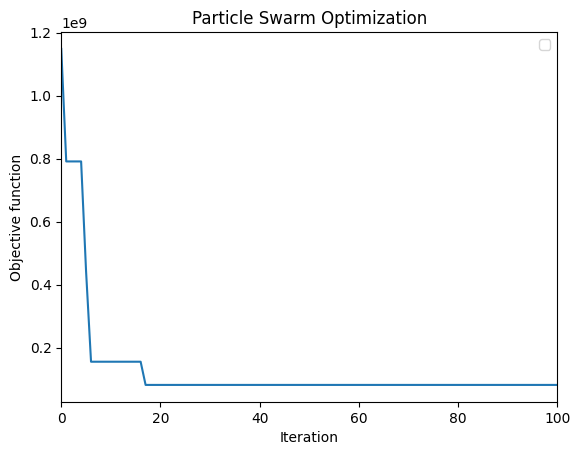

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 81181062.0808379
Tempo de Convergência para a segunda etapa: 1.5621497631072998 segundos


In [141]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization')


# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

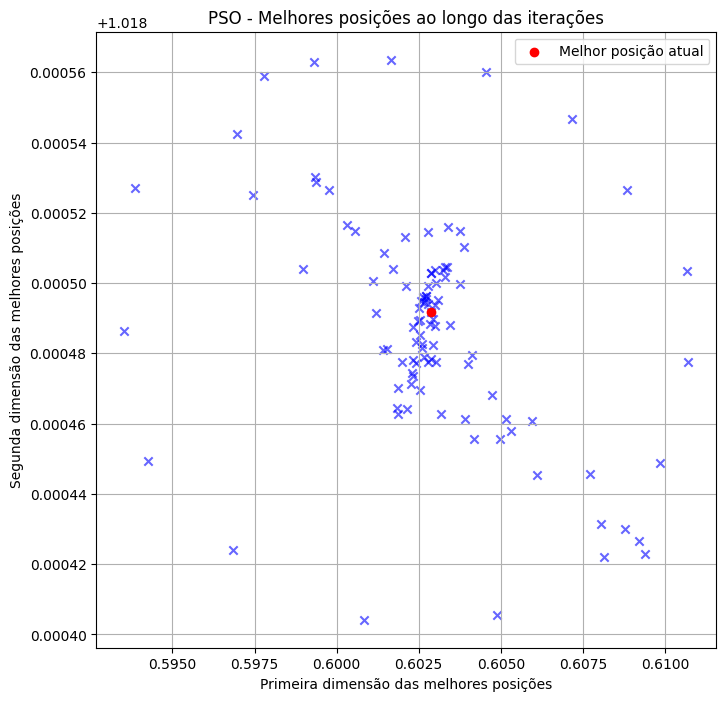

In [142]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [143]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [144]:
# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage,]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [145]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,1.836923e+08,123.599777,9.990589,0.249031,0.013235,1.680585,6
1,2,2.691567e+08,123.599777,9.990589,0.249031,0.017238,1.577729,12
2,3,1.006824e+08,123.599777,9.990589,0.249031,0.007868,1.539284,9
3,4,3.926515e+07,123.599777,9.990589,0.249031,0.007086,1.551805,4
4,5,6.145699e+07,123.599777,9.990589,0.249031,0.006705,1.580841,8
5,6,2.049194e+08,123.599777,9.990589,0.249031,0.012166,1.168965,11
6,7,6.901882e+07,123.599777,9.990589,0.249031,0.011530,1.642395,9
7,8,1.681880e+08,123.599777,9.990589,0.249031,0.008942,1.561278,8
8,9,1.767422e+08,123.599777,9.990589,0.249031,0.011288,1.463171,8
9,10,5.158344e+07,123.599777,9.990589,0.249031,0.009805,1.609056,7


In [146]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Index                        10 non-null     int64  
 1   Melhor_Custo                 10 non-null     float64
 2   Lambda                       10 non-null     float64
 3   Beta                         10 non-null     float64
 4   Theta                        10 non-null     float64
 5   Convergencia_Primeira_Etapa  10 non-null     float64
 6   Convergencia_Segunda_Etapa   10 non-null     float64
 7   Ciclos_MP                    10 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 768.0 bytes


In [147]:
resultado.describe()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,10.00000,1.000000e+01,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000
mean,5.50000,1.324705e+08,123.599777,9.990589,2.490307e-01,0.010586,1.537511,8.200000
std,3.02765,7.824523e+07,0.000000,0.000000,2.925695e-17,0.003217,0.142287,2.299758
min,1.00000,3.926515e+07,123.599777,9.990589,2.490307e-01,0.006705,1.168965,4.000000
25%,3.25000,6.334745e+07,123.599777,9.990589,2.490307e-01,0.008137,1.542414,7.250000
50%,5.50000,1.344352e+08,123.599777,9.990589,2.490307e-01,0.010547,1.569504,8.000000
75%,7.75000,1.819548e+08,123.599777,9.990589,2.490307e-01,0.012007,1.602002,9.000000
max,10.00000,2.691567e+08,123.599777,9.990589,2.490307e-01,0.017238,1.680585,12.000000


In [148]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

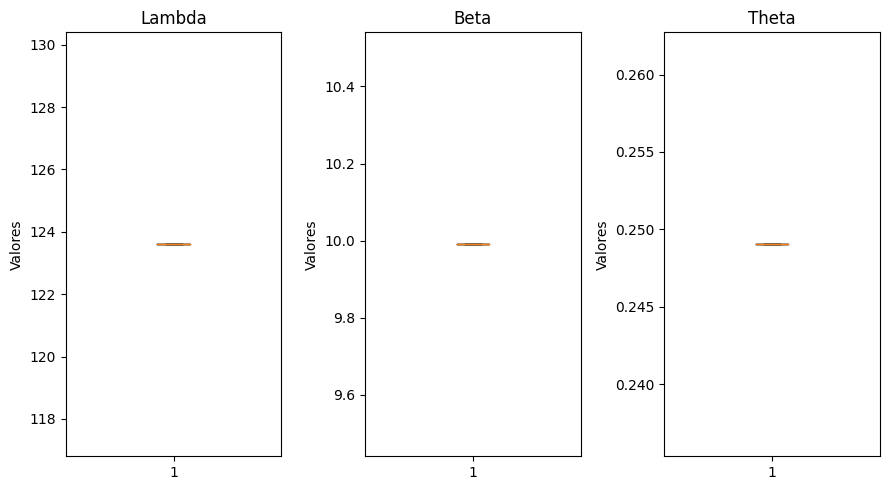

In [149]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

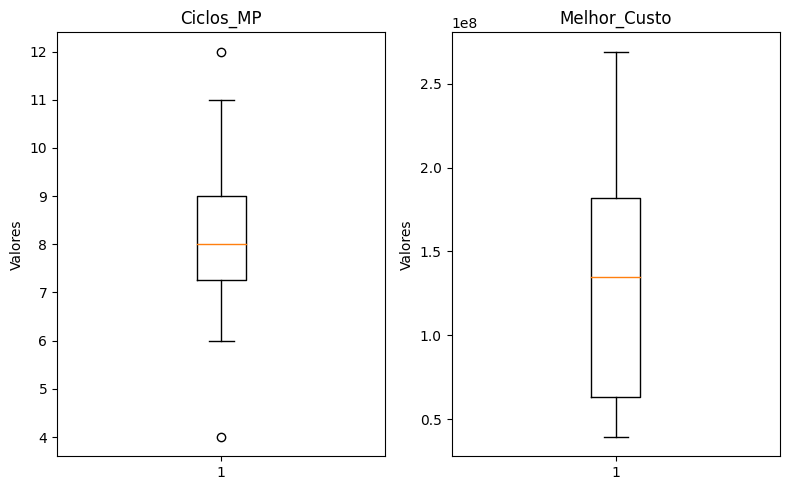

In [150]:
# Cria uma grafico para os parameros da segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_segunda_etapa):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

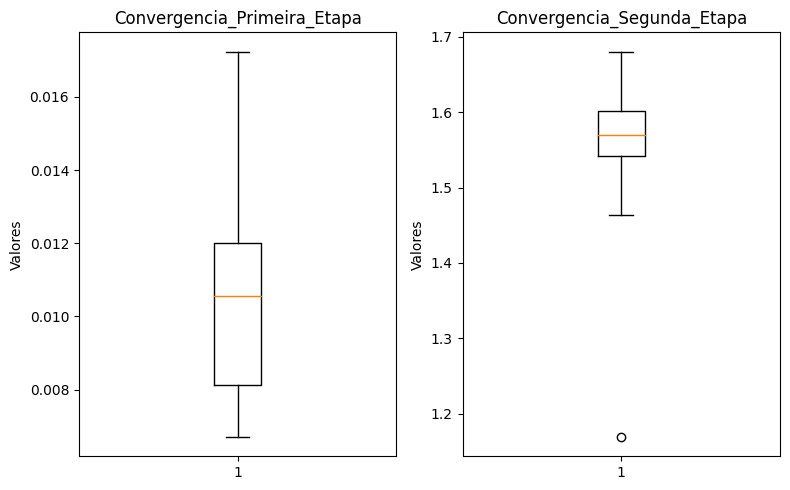

In [151]:
# Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(convergencia):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [152]:
# Arrays de tempos e severidade
Tempos = [
[[72, 137, 158, 209, 239, 276, 308, 340, 377, 466]],
[[9, 79, 155, 186, 234, 360, 531, 543]],
[[131, 208, 352, 403, 434, 514]],
[[78, 117, 177, 252, 274, 403, 478, 582]],
[[95, 138, 200, 282, 566]],
[[81, 105, 203, 233, 439, 464, 488, 623]],
[[98, 202, 216, 245, 317, 392]],
[[95, 163, 321, 359, 425, 460, 509]],
[[18, 37, 443, 617]],
[[60, 105, 122, 198, 242, 305, 342, 404, 432, 471]],
]

severidade = [
  [[0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]],
  [[0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5]],
  [[0.5, 0.5, 0.75, 0.25, 0.75, 0.5]],
  [[0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75]],
  [[0.25, 0.5, 0.75, 0.5, 0.75]],
  [[0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25]],
  [[0.75, 0.25, 0.75, 0.25, 0.5, 0.25]],
  [[0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25]],
  [[0.75, 0.5, 0.75, 0.5]],
  [[0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25]],
]

# # Verifica se ambos os arrays têm o mesmo número de linhas
# if len(Tempos) == len(severidade):
#     with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
#         file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
#         for i in range(len(Tempos)):
#             row = Tempos[i] + severidade[i]
#             row_str = [str(value) for value in row]
#             file.write(f"{i};{';'.join(row_str)}\n")
# else:
#     print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [153]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,"[48, 212, 360, 476, 485, 562]","[0.5, 0.5, 0.75, 0.25, 0.75, 0.25]"
1,"[9, 35, 171, 199, 240, 297, 324, 335, 403, 467...","[0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.25,..."
2,"[21, 50, 89, 235, 263, 290, 342, 436, 477]","[0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]"
3,"[4, 195, 265, 289]","[0.75, 0.75, 0.75, 0.5]"
4,"[39, 104, 128, 207, 293, 364, 416, 459]","[0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]"
5,"[8, 50, 129, 177, 268, 281, 347, 376, 428, 488...","[0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75,..."
6,"[118, 135, 174, 180, 216, 262, 302, 427, 459]","[0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5]"
7,"[127, 213, 253, 321, 441, 460, 495, 515]","[0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75]"
8,"[1, 149, 168, 267, 275, 401, 461, 557]","[0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75]"
9,"[74, 127, 163, 187, 215, 390, 427]","[0.75, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5]"


In [154]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Tempos_Manutencoes_Preventivas  10 non-null     object
 1   Severidade_subsistema           10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [155]:
dados.describe()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
count,10,10
unique,10,10
top,"[48, 212, 360, 476, 485, 562]","[0.5, 0.5, 0.75, 0.25, 0.75, 0.25]"
freq,1,1
